# Preset and definition of variables

In [1]:
import os

import mne_nirs
import mne_nirs.io
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)

import mne_bids.stats

import mne
import mne.io

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt


%matplotlib inline 

Download data for the creation of surface images.

In [2]:
# Download anatomical locations
subjects_dir = os.path.join(mne.datasets.sample.data_path(), 'subjects')
mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)


0 files missing from root.txt in /Users/brunomiguel/mne_data/MNE-sample-data/subjects
0 files missing from bem.txt in /Users/brunomiguel/mne_data/MNE-sample-data/subjects/fsaverage


'/Users/brunomiguel/mne_data/MNE-sample-data/subjects/fsaverage'

# 0. Select data

Select data in the BIDS format. Set the root to the folder and number of the run.

In [3]:
# Participant id.
p_id = 'S01'

# write data_path using p_id.
data_path = os.path.join('..', 'data', p_id, 'nirs')

print(data_path)

# Run id.
run_id = '1'

../data/S01/nirs


Get snirf file for participant 'p_id' and run 'run_id'. Load data to the raw_intensity variable.

In [4]:
# Create an empty list to store the raw intensity data
raw_intensity = []

# Get files with .snirf extension using os
snirf_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.snirf')]

# select file that contains run_id in its name
snirf_file = [f for f in snirf_files if run_id in f]

if snirf_file:
    # Load the data in snirf_file
    raw_intensity = mne.io.read_raw_snirf(snirf_file[0], preload=True)

    raw_intensity.load_data()

else:
    
    print('No snirf file found')



Loading /Users/brunomiguel/Documents/GitHub/NIRS-UCP/scripts/../data/S01/nirs/sub-S01_task-music_run-1.snirf
Reading 0 ... 2445  =      0.000 ...   194.133 secs...


# 1. Annotations, check for types of triggers and renaming

The triggers codes correspondence: "1": "Baseline", "2": "Q1", "3": "Q2", "4": "Q3", "5": "Q4", "8": "Begin", "9": "End"


In [5]:
# reset duration of conditions

raw_intensity.annotations.set_durations(7.5)

# rename conditions
# raw_intensity.annotations.rename( {"1": "Baseline","2": "Q1","3": "Q2", "4": "Q3", "5": "Q4", "8": "Begin","9": "End"} )

raw_intensity.annotations.rename( {"1": "Baseline",
                                    "2": "M",
                                    "3": "M",
                                    "4": "M",
                                    "5": "M",
                                    "8": "init",
                                    "9": "end"} 
                                )



<Annotations | 19 segments: Baseline (5), M (12), end (1), init (1)>

**Crop data considering begin and end triggers.**

Get onset for the trigger init and end. Crop data on these markers. Remove annotations outside this period from the data structure.


In [6]:
# Trim Data
# from trigger 8 to trigger 9 
tmin = raw_intensity.annotations[raw_intensity.annotations.description == "init"].onset

tmax = raw_intensity.annotations[raw_intensity.annotations.description == "end"].onset

timeatorigin = raw_intensity.annotations.orig_time

print(timeatorigin, tmin, tmax)

dur = tmax-tmin
print (dur)

duration_min=dur/60
print (duration_min)


2024-05-02 12:45:19+00:00 [2.06336] [181.25824]
[179.19488]
[2.98658133]


In [7]:
# import datetime 

# deltamin = datetime.timedelta(seconds=tmin[0] + 1)   
# deltamax = datetime.timedelta(seconds=tmax[0] + 1) 

# annots = raw_intensity.annotations.crop( timeatorigin + deltamin, timeatorigin + deltamax, use_orig_time=False )


In [8]:
# Remove annotations outside of the trimmed data
raw_intensity.annotations.delete(raw_intensity.annotations.onset <= tmin[0])
raw_intensity.annotations.delete(raw_intensity.annotations.onset >= tmax[0])

In [9]:
raw_intensity.crop( tmin[0], tmax[0] )



Measurement date,"May 02, 2024 12:45:19 GMT"
Experimenter,Unknown
Participant,
Digitized points,300 points
Good channels,268 fNIRS (CW amplitude)
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,12.59 Hz
Highpass,0.00 Hz
Lowpass,6.30 Hz


# 2. Conversion from CW to haemoglobin data.

In [10]:
# Convert NIRS raw data to optical density.
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)


[Text(0.5, 0, 'Scalp Coupling Index'), Text(0, 0.5, 'Count'), (0.0, 1.0)]

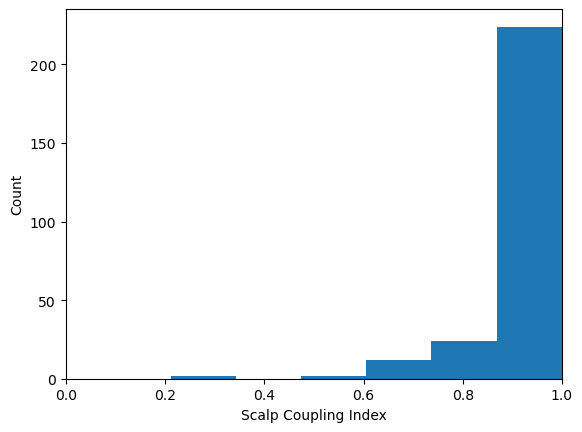

In [11]:
# TODO: https://mne.tools/mne-nirs/stable/auto_examples/general/plot_22_quality.html

sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
fig, ax = plt.subplots()
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])

We can mark these as bad in the MNE data. This way the functions downstream will know that the data in these channels is bad. For this example we set the threshold for a bad channel to be SCI < 0.7. We then print a list of the bad channels.

In [12]:
# Select raw_od channels with sci < 0.7

from itertools import compress


# raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.7))
# print(raw_od.info['bads'])

# raw_od.plot_sensors();

TDDR was initially designed to be used on optical density fNIRS data but has been enabled to be applied on hemoglobin concentration fNIRS data as well in MNE. We recommend applying the algorithm to optical density fNIRS data as intended by the original author wherever possible.

There is a shorter alias mne.preprocessing.nirs.tddr that can be used instead of this function (e.g. if line length is an issue).

In [13]:
raw_tddr_od = mne.preprocessing.nirs.tddr(raw_od)


In [14]:

# Convert optical density data to haemoglobin data (ppf - The partial pathlength factor).
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_tddr_od, ppf=6.0)


## 2.1 Preprocessing

In [15]:
raw_haemo = raw_haemo.filter(None, 
                             0.5, 
                             h_trans_bandwidth=0.5,
                             l_trans_bandwidth=0.01)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.75 Hz)
- Filter length: 85 samples (6.749 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


## 2.2 Channel selection

In [16]:
# Return channels with a long source detector separation.
short_haemo = mne_nirs.channels.get_short_channels(raw_haemo, max_dist=0.01)

# Return channels with a long source detector separation.
long_haemo = mne_nirs.channels.get_long_channels(raw_haemo)

In [17]:
mne_nirs.channels.list_sources(long_haemo)
print(long_haemo.ch_names)

['S1_D1 hbo', 'S1_D2 hbo', 'S1_D28 hbo', 'S2_D1 hbo', 'S2_D2 hbo', 'S2_D4 hbo', 'S3_D1 hbo', 'S3_D4 hbo', 'S4_D2 hbo', 'S4_D3 hbo', 'S4_D5 hbo', 'S4_D26 hbo', 'S5_D3 hbo', 'S5_D4 hbo', 'S5_D6 hbo', 'S6_D4 hbo', 'S7_D3 hbo', 'S7_D5 hbo', 'S7_D6 hbo', 'S7_D7 hbo', 'S8_D4 hbo', 'S8_D6 hbo', 'S8_D8 hbo', 'S9_D5 hbo', 'S9_D7 hbo', 'S9_D9 hbo', 'S9_D23 hbo', 'S10_D6 hbo', 'S10_D7 hbo', 'S10_D8 hbo', 'S10_D10 hbo', 'S11_D8 hbo', 'S11_D11 hbo', 'S12_D7 hbo', 'S12_D9 hbo', 'S12_D10 hbo', 'S12_D12 hbo', 'S13_D8 hbo', 'S13_D10 hbo', 'S13_D11 hbo', 'S13_D13 hbo', 'S14_D9 hbo', 'S14_D12 hbo', 'S14_D19 hbo', 'S15_D10 hbo', 'S15_D12 hbo', 'S15_D13 hbo', 'S15_D14 hbo', 'S16_D11 hbo', 'S16_D13 hbo', 'S17_D14 hbo', 'S17_D15 hbo', 'S17_D18 hbo', 'S18_D15 hbo', 'S18_D17 hbo', 'S18_D18 hbo', 'S19_D14 hbo', 'S19_D15 hbo', 'S19_D16 hbo', 'S20_D15 hbo', 'S20_D16 hbo', 'S20_D17 hbo', 'S21_D18 hbo', 'S21_D19 hbo', 'S21_D20 hbo', 'S21_D21 hbo', 'S22_D20 hbo', 'S22_D22 hbo', 'S23_D9 hbo', 'S23_D19 hbo', 'S23_D21 

# 3. GLM analysis

## 3.1 design matrix

3.1.1 Events data

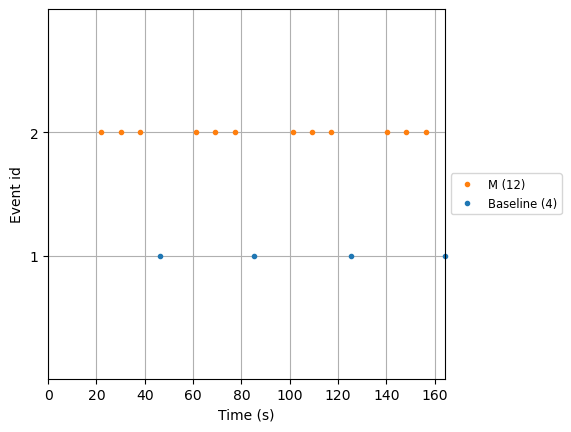

In [18]:
events, event_dict = mne.events_from_annotations(raw_haemo, verbose=False)
mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_haemo.info['sfreq']);



In [19]:
def _update_designmatrix(df):
    """
    Label trials for an LSA model.

    Parameters:
    - df: DataFrame containing trial information.

    Returns:
    - df: Updated DataFrame with labeled trial types.
    """

    unique_conditions = df["trial_type"].unique()

    df["class"] = df["trial_type"]
    condition_counter = {condition: 0 for condition in unique_conditions}

    for i, trial in df.iterrows():
        trial_condition = trial["class"]
        condition_counter[trial_condition] += 1
        labeled_trial_name = f"{trial_condition}_{condition_counter[trial_condition]:03d}"
        df.loc[i, "trial_type"] = labeled_trial_name

    return df

In [20]:
events, event_dict = mne.events_from_annotations(long_haemo)


Used Annotations descriptions: ['Baseline', 'M']


In [21]:
# Events to dataframe.
events_df = pd.DataFrame(events, columns=["onset", "duration", "trial_type"])

# set duration to 7.5
events_df["duration"] = 7.5

# Update the design matrix.
events_df_lsa = _update_designmatrix(events_df)

events_df_lsa.head()



/var/folders/d_/lr6pgxv95sgf0gw5zh_09rs40000gn/T/ipykernel_75391/373585130.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.0_001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, "trial_type"] = labeled_trial_name


,onset,duration,trial_type,class
0,278,7.5,2.0_001,2
1,379,7.5,2.0_002,2
2,480,7.5,2.0_003,2
3,581,7.5,1.0_001,1
4,770,7.5,2.0_004,2


In [22]:
from mne_nirs.experimental_design import make_first_level_design_matrix


design_matrix = make_first_level_design_matrix(long_haemo,
                                               drift_model='polynomial',
                                               high_pass=0.005,  # Must be specified per experiment
                                               hrf_model='spm',
                                               stim_dur=7.5)


# Remove Baseline from design matrix
design_matrix = design_matrix.drop(columns=['Baseline'])





### 3.1.2 Short channels

In [23]:

# Add short channels to the design matrix
short_ch_names =  short_haemo.ch_names

# for each name in shortch_names
for name in short_ch_names:

    # get the data from the short channel    
    design_matrix[name] = short_haemo.copy().pick(picks=name).get_data().transpose()

### 3.1.3 Add auxiliary data - physio

In [24]:
snirf_file

['../data/S01/nirs/sub-S01_task-music_run-1.snirf',
 '../data/S01/nirs/sub-S01_task-music_run-2.snirf']

In [25]:
raw_intensity.info

Measurement date,"May 02, 2024 12:45:19 GMT"
Experimenter,Unknown
Participant,
Digitized points,300 points
Good channels,268 fNIRS (CW amplitude)
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,12.59 Hz
Highpass,0.00 Hz
Lowpass,6.30 Hz


In [26]:
import h5py
from scipy import interpolate

fname = snirf_file[0]


In [27]:
def _decode_name(key):
    return np.array(key).astype(str)

In [28]:
def _get_data_idx(timeseries, t_ref):
    """Get the index of the closest time point in the timeseries."""
    return np.argmin(np.abs(timeseries - t_ref))

In [29]:
def _trim_aux_data(aux_data, init_idx, end_idx):
    """Trim the auxiliary data to the specified time window."""
    if aux_data is None:
        return None
    else:
        return aux_data[init_idx:end_idx]
    

In [30]:
with h5py.File(fname, "r") as dat:
        if "nirs" in dat:
            basename = "nirs"
        elif "nirs1" in dat:
            basename = "nirs1"
        else:
            raise RuntimeError("Data does not contain nirs field")

        all_keys = list(dat.get(basename).keys())
        aux_keys = [i for i in all_keys if i.startswith("aux")]

        aux_names = [_decode_name(dat.get(f"{basename}/{k}/name")) for k in aux_keys]

        d = {"times": raw_haemo.times}
        for idx, aux in enumerate(aux_keys):
            aux_data = np.array(dat.get(f"{basename}/{aux}/dataTimeSeries"))
            aux_time = np.array(dat.get(f"{basename}/{aux}/time"))

            # print(aux_data.shape)
            trim_idx_init = _get_data_idx(aux_time, tmin)
            trim_idx_end = _get_data_idx(aux_time, tmax)

            aux_data = _trim_aux_data(aux_data, trim_idx_init, trim_idx_end)   
            aux_time = _trim_aux_data(aux_time, trim_idx_init, trim_idx_end)

            aux_data_interp = interpolate.interp1d(
                aux_time, aux_data, axis=0, bounds_error=False, fill_value="extrapolate"
            )
            aux_data_matched_to_raw = aux_data_interp(raw_haemo.times)
            
            # print(aux_data_matched_to_raw.ndim)

            # Remove single dimension
            if aux_data_matched_to_raw.ndim == 2:
                aux_data_matched_to_raw = aux_data_matched_to_raw[:,0]
            
            d[str(aux_names[idx])] = aux_data_matched_to_raw


        df = pd.DataFrame(data=d)
        df = df.set_index("times")

   

In [31]:
df

,ACCEL_X_1,ExGa4,ECG,Respiration,PPG,SpO2,Heartrate,GSR,Temperature,ACCEL_Y_1,ACCEL_Z_1,GYRO_X_1,GYRO_Y_1,GYRO_Z_1,ExGa1,ExGa2,ExGa3
times,,,,,,,,,,,,,,,,,
0.0000,7.017775,10.570205,0.007366,67.960401,16.320000,100.0,75.0,25.845417,21.3125,-22.923386,-15.755008,70.362512,-23.506405,13.339702,0.053079,8.554860,24.427391
0.0794,6.810381,10.163367,0.007086,68.870286,16.320000,100.0,75.0,25.915512,21.3125,-22.428831,-15.124849,67.929620,-22.533248,12.853124,0.051050,8.225228,23.485958
0.1588,6.602987,9.756530,0.006806,69.780170,16.320000,100.0,75.0,25.985608,21.3125,-21.934276,-14.494690,65.496729,-21.560092,12.366546,0.049021,7.895597,22.544525
0.2382,6.395593,9.349692,0.006526,70.690054,16.320000,100.0,75.0,26.055703,21.3125,-21.439721,-13.864532,63.063838,-20.586935,11.879968,0.046991,7.565965,21.603092
0.3176,6.188199,8.942854,0.006246,71.599939,16.320000,100.0,75.0,26.125798,21.3125,-20.945166,-13.234373,60.630946,-19.613779,11.393389,0.044962,7.236333,20.661658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178.8882,1.691533,-0.031498,0.000041,92.203796,16.334000,100.0,70.0,35.495811,21.5000,-10.039893,0.768332,0.332650,-0.366000,0.199252,0.000855,-0.030338,-0.084252
178.9676,1.584844,-0.027600,0.000056,91.905769,16.372999,100.0,70.0,35.492781,21.4375,-10.047248,0.695174,-0.888018,-0.127037,0.310037,0.000861,-0.028220,-0.080192
179.0470,1.642540,-0.022876,0.000155,91.859924,16.500999,100.0,70.0,35.494389,21.4375,-10.040464,0.736857,0.276687,-0.300626,0.450939,0.000868,-0.025572,-0.075265


In [32]:
design_matrix.shape

(2258, 67)

In [33]:

# Add physio data in df to the design matrix
design_matrix = design_matrix.join(df, how='outer')

design_matrix


,M,drift_1,constant,S1_D29 hbo,S2_D30 hbo,S3_D31 hbo,S4_D32 hbo,S5_D33 hbo,S6_D34 hbo,S7_D35 hbo,...,GSR,Temperature,ACCEL_Y_1,ACCEL_Z_1,GYRO_X_1,GYRO_Y_1,GYRO_Z_1,ExGa1,ExGa2,ExGa3
0.0000,0.000000,-0.500000,1.0,-0.000001,-3.958009e-07,-5.291246e-07,-7.139089e-07,-5.448821e-07,2.597118e-08,-3.840469e-07,...,25.845417,21.3125,-22.923386,-15.755008,70.362512,-23.506405,13.339702,0.053079,8.554860,24.427391
0.0794,0.000000,-0.499557,1.0,-0.000001,-3.619650e-07,-5.639259e-07,-6.824796e-07,-5.088870e-07,5.249553e-08,-4.016540e-07,...,25.915512,21.3125,-22.428831,-15.124849,67.929620,-22.533248,12.853124,0.051050,8.225228,23.485958
0.1588,0.000000,-0.499114,1.0,-0.000001,-3.293992e-07,-5.949289e-07,-6.519831e-07,-4.738907e-07,7.790645e-08,-4.190341e-07,...,25.985608,21.3125,-21.934276,-14.494690,65.496729,-21.560092,12.366546,0.049021,7.895597,22.544525
0.2382,0.000000,-0.498671,1.0,-0.000001,-2.992844e-07,-6.188146e-07,-6.232739e-07,-4.407350e-07,1.013058e-07,-4.359780e-07,...,26.055703,21.3125,-21.439721,-13.864532,63.063838,-20.586935,11.879968,0.046991,7.565965,21.603092
0.3176,0.000000,-0.498228,1.0,-0.000001,-2.724421e-07,-6.330701e-07,-5.969876e-07,-4.100142e-07,1.219355e-07,-4.523188e-07,...,26.125798,21.3125,-20.945166,-13.234373,60.630946,-19.613779,11.393389,0.044962,7.236333,20.661658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178.8882,-0.069133,0.498228,1.0,-0.000001,-4.052265e-07,-6.230896e-07,-6.387794e-07,-5.845557e-07,1.605989e-08,-3.236202e-07,...,35.495811,21.5000,-10.039893,0.768332,0.332650,-0.366000,0.199252,0.000855,-0.030338,-0.084252
178.9676,-0.067804,0.498671,1.0,-0.000001,-4.670334e-07,-6.299979e-07,-6.866820e-07,-6.434219e-07,5.359158e-09,-3.184863e-07,...,35.492781,21.4375,-10.047248,0.695174,-0.888018,-0.127037,0.310037,0.000861,-0.028220,-0.080192
179.0470,-0.066486,0.499114,1.0,-0.000001,-5.406937e-07,-6.391271e-07,-7.497234e-07,-7.127228e-07,-6.892595e-09,-3.167939e-07,...,35.494389,21.4375,-10.040464,0.736857,0.276687,-0.300626,0.450939,0.000868,-0.025572,-0.075265
179.1264,-0.065180,0.499557,1.0,-0.000001,-6.229492e-07,-6.499067e-07,-8.237662e-07,-7.894990e-07,-2.027267e-08,-3.176500e-07,...,35.500208,21.4375,-10.052367,0.710083,0.728270,0.329905,0.476811,0.000871,-0.022771,-0.069215


### 3.1.4 Plotting the design matrix

/opt/anaconda3/envs/MNE-NIRS/lib/python3.12/site-packages/nilearn/plotting/matrix_plotting.py:503: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


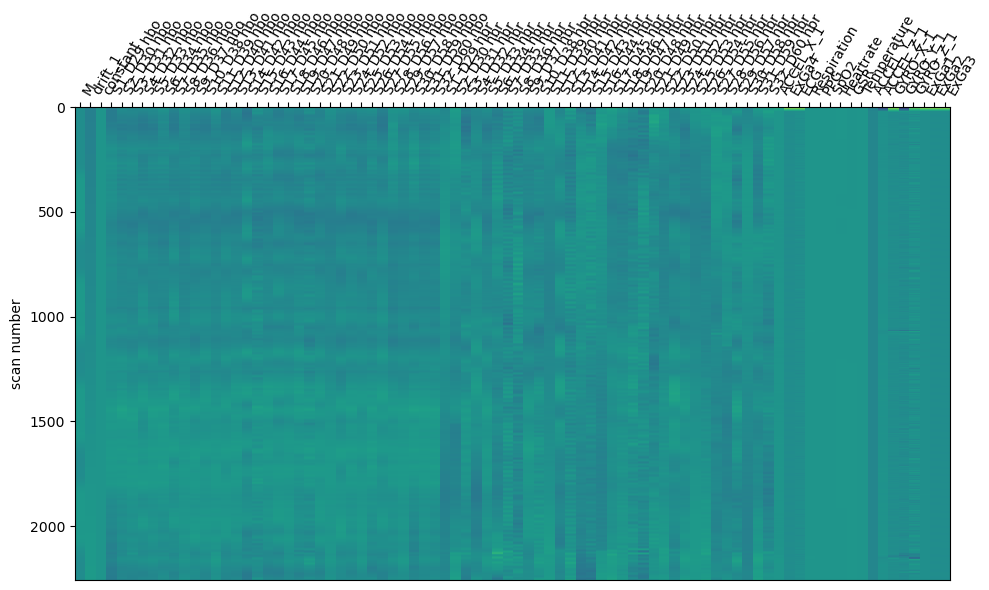

In [34]:
from nilearn.plotting import plot_design_matrix

fig, ax1 = plt.subplots(figsize=(10, 6), constrained_layout=True)
fig = plot_design_matrix(design_matrix, ax=ax1)


Used Annotations descriptions: ['Baseline', 'M']


[Text(0.5, 0, 'Time (s)'), Text(0, 0.5, 'Amplitude')]

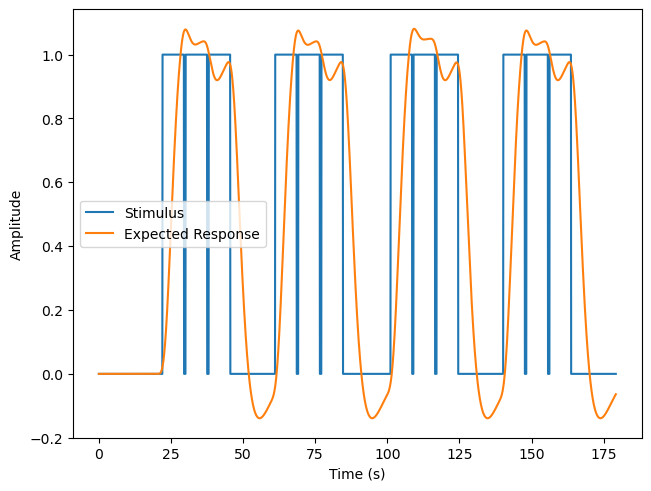

In [35]:
fig, ax = plt.subplots(constrained_layout=True)

s = mne_nirs.experimental_design.create_boxcar(raw_intensity, stim_dur=7.5)

ax.plot(raw_intensity.times, s[:, 1])
ax.plot(design_matrix['M'])
ax.legend(["Stimulus", "Expected Response"])
ax.set( xlabel="Time (s)", ylabel="Amplitude")

## 3.2 Fit GLM to data and estimate response for Music experimental condition

In [64]:
from mne_nirs.statistics import run_glm

glm_est = run_glm(long_haemo, design_matrix, noise_model='ar1') # ar(1)


In [65]:

df_glm = glm_est.to_dataframe()

df_glm.head()

variable,Condition,df,mse,p_value,se,t,theta,Source,Detector,Chroma,Significant,ch_name
168,ACCEL_X_1,84.0,7.308324e-18,0.922171,1.300229e-09,0.097993,1.274136e-10,11,8,hbo,False,S11_D8 hbo
169,ACCEL_Y_1,84.0,7.308324e-18,0.640321,3.141566e-09,0.468949,1.473234e-09,11,8,hbo,False,S11_D8 hbo
170,ACCEL_Z_1,84.0,7.308324e-18,0.901931,1.446212e-09,-0.123595,-1.787441e-10,11,8,hbo,False,S11_D8 hbo
171,ECG,84.0,7.308324e-18,0.704816,1.065041e-06,-0.380120,-4.048432e-07,11,8,hbo,False,S11_D8 hbo
172,ExGa1,84.0,7.308324e-18,0.000299,1.524442e-05,3.773812,5.752960e-05,11,8,hbo,True,S11_D8 hbo


In [66]:
# rows of the dataframe with the condition M or Baseline and ch_name contains hbo without using query

# df_glm_M = df_glm.query('Condition in ["M"] and ch_name.str.contains("hbo")', engine='python')

df_glm_M = df_glm.query('Condition in ["M"]', engine='python')



Text(0, 0.5, 't-value')

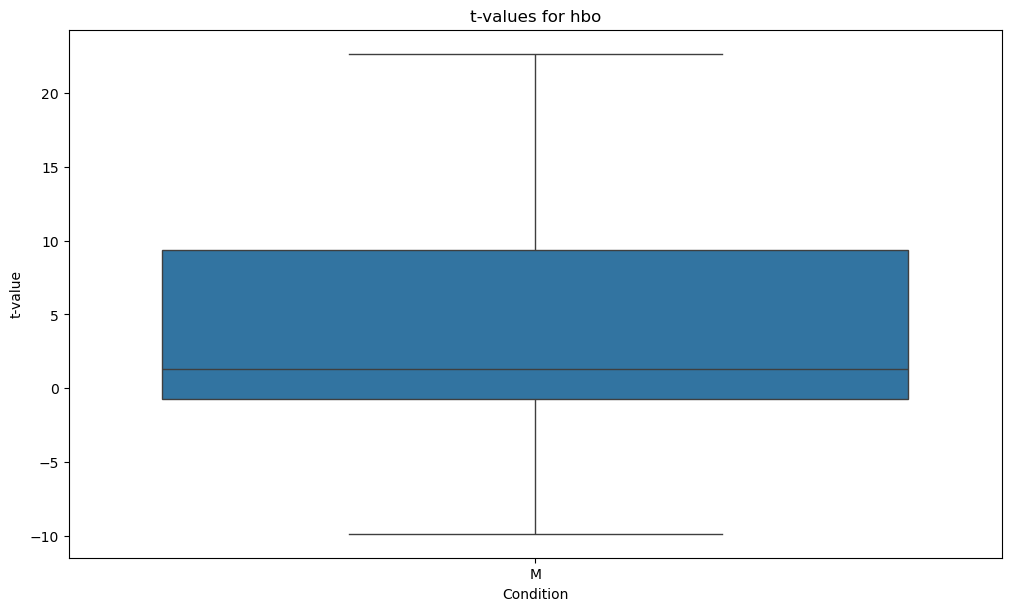

In [67]:
# plot boxplot of the df_glm_M t values using seaborn using Condition as x
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
sns.boxplot(data=df_glm_M, x='Condition', y='t', ax=ax)
ax.set_title('t-values for hbo')
ax.set_ylabel('t-value')


In [68]:
# sort channels by t-value
df_glm_M_sorted = df_glm_M.sort_values(by='t', ascending=False)

# get the top 5 channels
top_channels = df_glm_M_sorted.ch_name.unique()[:10]

print(df_glm_M_sorted.head())

variable Condition    df           mse       p_value            se          t  \
13               M  84.0  1.584780e-17  1.392573e-37  3.988918e-09  22.689628   
601              M  84.0  9.858056e-18  2.263520e-30  3.146054e-09  17.879124   
265              M  84.0  1.205424e-17  2.769662e-19  3.478889e-09  11.680102   
517              M  84.0  2.810373e-17  1.949429e-02  5.311933e-09   2.381666   
181              M  84.0  7.308324e-18  3.201459e-02  2.708816e-09   2.180535   

variable         theta  Source  Detector Chroma  Significant      ch_name  
13        9.050707e-08      10        10    hbo         True  S10_D10 hbo  
601       5.624870e-08      23        19    hbo         True  S23_D19 hbo  
265       4.063378e-08      12        12    hbo         True  S12_D12 hbo  
517       1.265125e-08      15        13    hbo         True  S15_D13 hbo  
181       5.906668e-09      11         8    hbo         True   S11_D8 hbo  


In [69]:
list_top_channels =top_channels.tolist()

/var/folders/d_/lr6pgxv95sgf0gw5zh_09rs40000gn/T/ipykernel_75391/2298896102.py:3: FutureWarning: vmin and vmax are deprecated and will be removed in the next release, please use vlim instead
  glm_est.pick(picks=list_top_channels).plot_topo(conditions='M',vmin=-1, vmax=1);


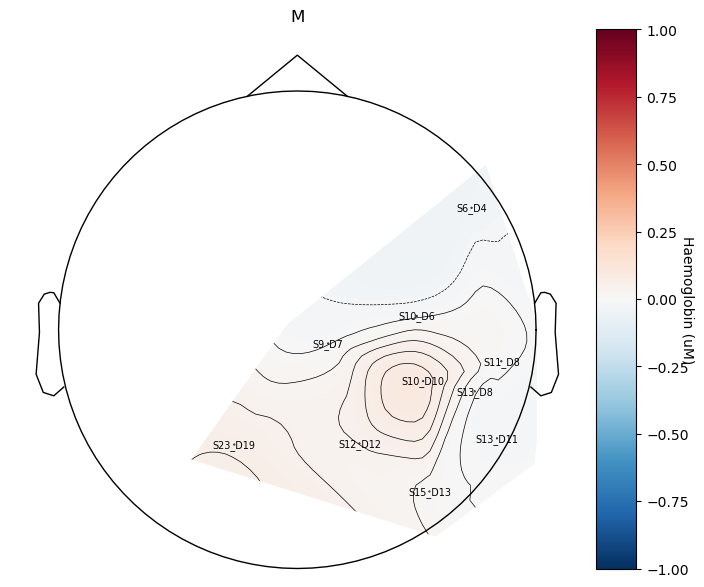

In [70]:
# Fit GLM to all data and view topographic distribution

glm_est.pick(picks=list_top_channels).plot_topo(conditions='M',vmin=-1, vmax=1);


In [71]:
# glm_est.copy().surface_projection(condition="M", view="dorsal", chroma="hbo")

# 4. Connectivity

In [76]:
tmin, tmax = -5, 15

epochs = mne.Epochs(long_haemo, 
                    events, 
                    event_id=event_dict,
                    tmin=tmin, tmax=tmax)

Not setting metadata
16 matching events found
Setting baseline interval to [-5.0022, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [75]:
epochs.info

Measurement date,"May 02, 2024 12:45:19 GMT"
Experimenter,Unknown
Participant,
Digitized points,300 points
Good channels,10 Oxyhemoglobin
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,12.59 Hz
Highpass,0.00 Hz
Lowpass,0.50 Hz


Using data from preloaded Raw for 12 events and 253 original time points ...
0 bad epochs dropped
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


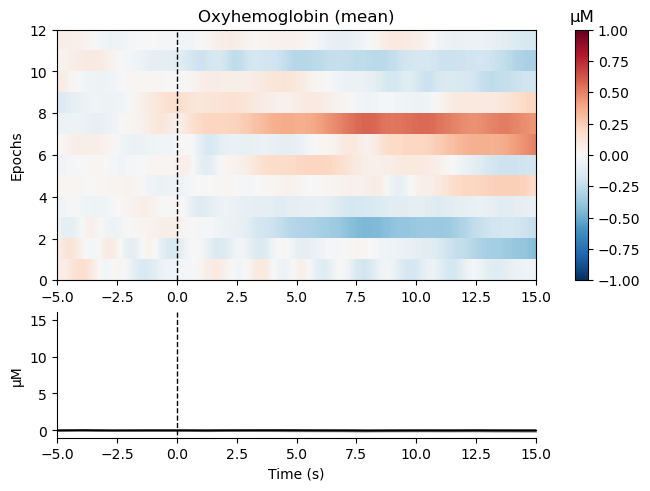

[<Figure size 640x480 with 3 Axes>]

In [77]:
# Combine epochs - epochs['M'] = concat of all epochs with condition M1, M2, M3, M4

epochs['M'].plot_image(combine='mean', vmin=-1, vmax=1,
                             ts_args=dict(ylim=dict(hbo=[-1, 16],
                                                    hbr=[-1, 16])))

combining channels using "mean"


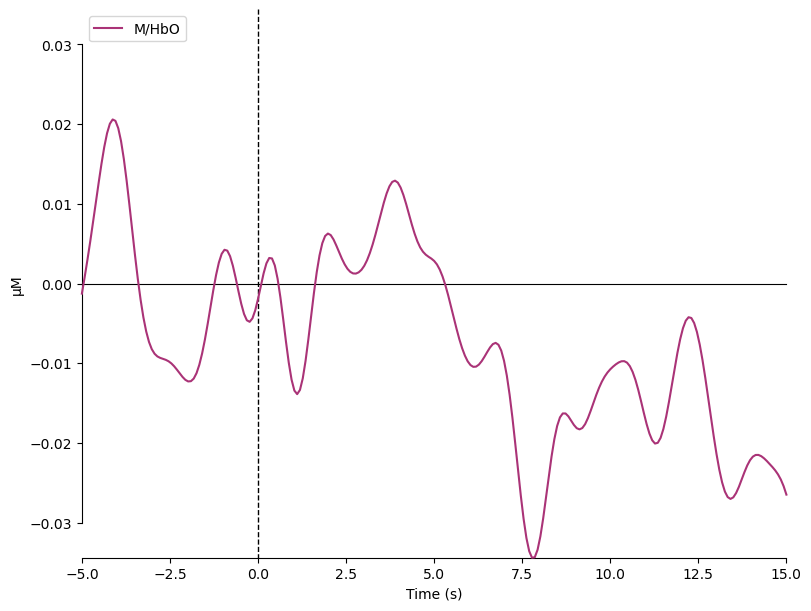

[<Figure size 800x600 with 1 Axes>]

In [80]:
evoked_dict = {'M/HbO': epochs['M'].average(picks='hbo')}

# Rename channels until the encoding of frequency in ch_name is fixed
for condition in evoked_dict:
    evoked_dict[condition].rename_channels(lambda x: x[:-4])

color_dict = dict(HbO='#AA3377')

mne.viz.plot_compare_evokeds(evoked_dict, combine="mean", ci=0.95,
                             colors=color_dict)

In [82]:
import mne_connectivity

from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_sensors_connectivity


con = spectral_connectivity_epochs(
    epochs,
)


Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 45 connections
    using t=-5.002s..15.007s for estimation (253 points)
    frequencies: 0.2Hz..6.3Hz (122 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
    computing cross-spectral density for e

In [84]:
conmat = con.get_data()

conmat_sq = conmat[:,0].reshape(10, 10)

In [85]:
conmat_sq

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.9194012 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.8326879 , 0.88858383, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.9366078 , 0.90374171, 0.78927669, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.90277445, 0.91106567, 0.82413557, 0.94841432, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.76716209, 0.70713507, 0.60255328, 0.85982036, 0.79454663,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.92077787, 0.87663435, 0.79736915, 0.91984659, 0.86667985,
        0.80783727, 0.        , 0.        , 0.        , 0.        ],
       [0.77637442, 0.74000099, 0.6597016

In [90]:
mne_connectivity.viz.plot_sensors_connectivity(epochs.info, conmat_sq)

<Axes: >

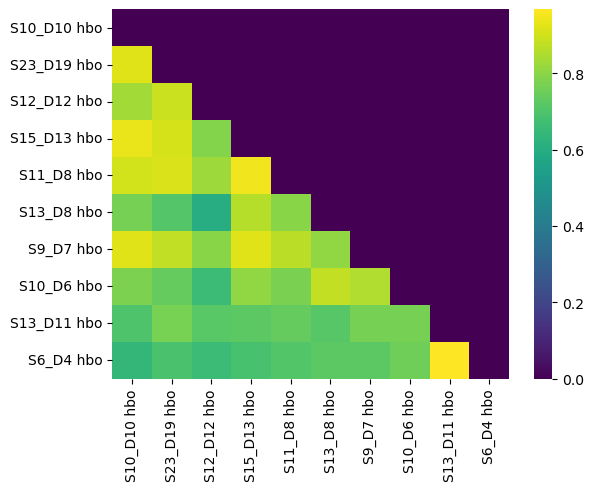

In [89]:
import seaborn as sns

sns.heatmap(conmat_sq, cmap='viridis', xticklabels=top_channels, yticklabels=top_channels)

# 5. Save data

In [ ]:
from mne_nirs.io import write_raw_snirf


# write data_path using p_id.
derivatives_data_path = os.path.join('..', 'data', 'derivatives', 'mne-nirs', p_id)

if not os.path.exists(derivatives_data_path):
    os.makedirs(derivatives_data_path)

print(derivatives_data_path)


# write_raw_snirf(long_haemo, os.path.join(derivatives_data_path, f'{p_id}_{run_id}_long_haemo.snirf'))